In [1]:
import numpy as np
import pandas as pd
import psycopg2
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [4]:
from sqlalchemy import create_engine

postgres_str = ('postgresql://localhost/crossvalidated')
cnx = create_engine(postgres_str)

In [5]:
pd.read_sql_query('''SELECT * FROM Posts LIMIT 5;''', cnx)

,id,posttypeid,acceptedanswerid,parentid,creationdate,score,viewcount,body,owneruserid,lasteditoruserid,...,lasteditdate,lastactivitydate,title,tags,answercount,commentcount,favoritecount,closeddate,communityowneddate,jsonfield
0,1,1,15.0,NaN,2010-07-19 19:12:12.510,42,3654.0,<p>How should I elicit prior distributions fro...,8,NaN,...,NaT,2018-12-29 18:42:01.680,Eliciting priors from experts,<bayesian><prior><elicitation>,5.0,1,29.0,None,NaT,None
1,2,1,59.0,NaN,2010-07-19 19:12:57.157,31,30036.0,<p>In many different statistical methods there...,24,NaN,...,2010-08-07 17:56:44.800,2017-11-22 12:15:07.030,What is normality?,<distributions><normality-assumption>,7.0,1,11.0,None,NaT,None
2,3,1,5.0,NaN,2010-07-19 19:13:28.577,69,6221.0,<p>What are some valuable Statistical Analysis...,18,183.0,...,2011-02-12 05:50:03.667,2013-05-27 14:48:36.927,What are some valuable Statistical Analysis op...,<software><open-source>,19.0,3,40.0,None,2010-07-19 19:13:28.577,None
3,4,1,135.0,NaN,2010-07-19 19:13:31.617,21,35577.0,<p>I have two groups of data. Each with a dif...,23,NaN,...,NaT,2010-09-08 03:00:19.690,Assessing the significance of differences in d...,<distributions><statistical-significance>,5.0,2,11.0,None,NaT,None
4,5,2,NaN,3.0,2010-07-19 19:14:43.050,88,NaN,"<p>The R-project</p>\n\n<p><a href=""http://www...",23,23.0,...,2010-07-19 19:21:15.063,2010-07-19 19:21:15.063,None,None,NaN,3,NaN,None,2010-07-19 19:14:43.050,None


**Various measures**

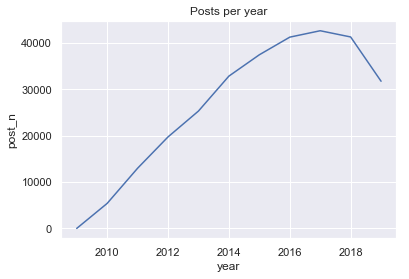

In [6]:
posts_per_year = pd.read_sql_query(
                    '''SELECT CAST(date_part('year', CreationDate) AS INTEGER) AS Year, COUNT(*) AS Post_n
                    FROM Posts
                    GROUP BY date_part('year', CreationDate);''', cnx)
sns.lineplot(x=posts_per_year['year'], y=posts_per_year['post_n']).set_title('Posts per year')
plt.show()

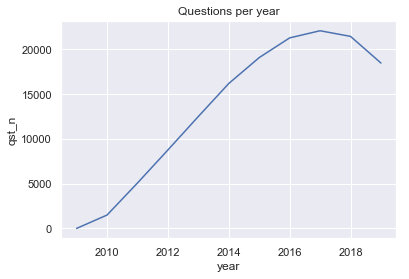

In [7]:
questions_per_year = pd.read_sql_query(
                    '''SELECT CAST(date_part('year', CreationDate) AS INTEGER) AS Year, COUNT(*) AS qst_n
                    FROM Posts
                    WHERE ParentId IS NULL
                    GROUP BY date_part('year', CreationDate);''', cnx)
sns.lineplot(x=questions_per_year['year'], y=questions_per_year['qst_n']).set_title('Questions per year')
plt.show()

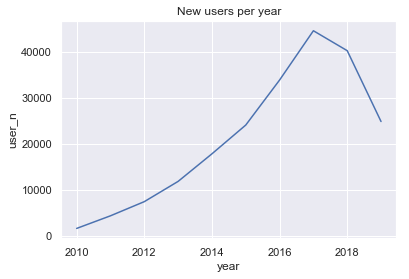

In [8]:
newusers_per_year = pd.read_sql_query(
                    '''SELECT CAST(date_part('year', CreationDate) AS INTEGER) AS Year, COUNT(*) AS User_n
                    FROM Users
                    GROUP BY date_part('year', CreationDate);''', cnx)
sns.lineplot(x=newusers_per_year['year'], y=newusers_per_year['user_n']).set_title('New users per year')
plt.show()

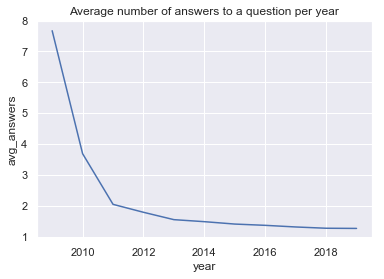

In [9]:
avg_ans_per_year = pd.read_sql_query(
        '''SELECT Year, AVG(c_answers) AS Avg_answers FROM (
        SELECT Q.Id, CAST(date_part('year', Q.CreationDate) AS INTEGER) AS Year, COUNT(*) AS c_answers
        FROM Posts AS Q JOIN Posts AS Ans ON Q.Id=Ans.ParentId
        GROUP BY Q.Id) AS anstable
        GROUP BY Year
        ORDER BY Year ASC;''', cnx)
sns.lineplot(x=avg_ans_per_year['year'], y=avg_ans_per_year['avg_answers']).set_title('Average number of answers to a question per year')
plt.show()

In [16]:
print("Percentage of users that wrote more than x answers:")
for i in [1,2,5,10]:
    avg_ans_per_year = pd.read_sql_query(
            '''with countPerUser as (Select OwnerUserId, count(OwnerUserId) as c from Posts where ParentId is not null group by OwnerUserId)
    Select (Select CAST(Count(c) AS float) from countPerUser where c>%i)/CAST(Count(c) AS float) from countPerUser'''%i, cnx)
    print("Users with more than ", i, " answers: ", avg_ans_per_year.values[0,0]*100)

Percentage of users that wrote more than x answers:
Users with more than  1  answers:  36.4093059552261
Users with more than  2  answers:  24.2110910598449
Users with more than  5  answers:  12.8469004535922
Users with more than  10  answers:  7.48183192703507


In [20]:
print("Percentage of users that wrote more than x questions:")
for i in [1,2,5,10]:
    avg_ans_per_year = pd.read_sql_query(
            '''with countPerUser as (Select OwnerUserId, count(OwnerUserId) as c from Posts where ParentId is null group by OwnerUserId)
    Select (Select CAST(Count(c) AS float) from countPerUser where c>%i)/CAST(Count(c) AS float) from countPerUser'''%i, cnx)
    print("Users with more than ", i, " question: ", avg_ans_per_year.values[0,0]*100)

Percentage of users that wrote more than x questions:
Users with more than  1  question:  31.7843485923804
Users with more than  2  question:  17.893842352904098
Users with more than  5  question:  6.5227312068233
Users with more than  10  question:  2.61223975954805
